#### **Imports**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics


In [6]:
import seaborn as sns
sns.set()

#### **Define the Energy Model**

In [7]:
# define the model
np.random.seed(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) : 45 / 45
Non-zero Bias (h) : 9 / 10
---------------------------------------------
Average Interaction Strength <|J|> :  0.5966799999999999
Average Bias Strength <|h|>:  0.5010000000000001
alpha :  0.5606804251097042
---------------------------------------------


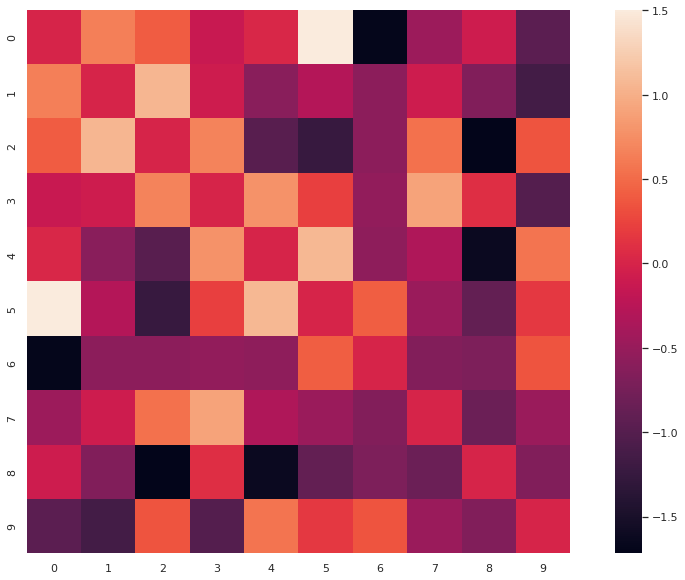

In [8]:
model.model_summary()

#### **Exact Analysis**

In [9]:
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

Running Exact Sampling | beta :  1.100209


running over all possible configurations: 100%|██████████| 1024/1024 [00:00<00:00, 17123.84it/s]

saving distribution to model ...


     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 12
Entropy : 3.7838182697705967
---------------------------------------------


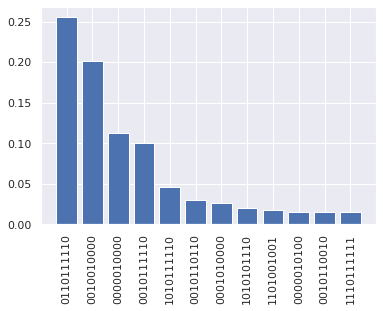

In [10]:
## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary()

#### **Run Classical MCMC**

In [11]:
steps = 10000
cl_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

starting with:  0101110110 with energy: 1.2780000000000005


running MCMC steps ...: 100%|██████████| 10000/10000 [00:01<00:00, 6351.47it/s]


In [12]:
cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)

#### **Run Quantum Enhaned MCMC**

In [13]:
steps = 10000
qamcmc_chain =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

starting with:  0000110110 with energy: -4.029999999999999
MCMCChain()


runnning quantum MCMC steps . ..: 100%|██████████| 10000/10000 [04:45<00:00, 34.97it/s]


In [14]:
qumcm_statistic = get_trajectory_statistics(qamcmc_chain, exact_sampled_model, verbose= False)

#### **Proposition Strategy Analysis**

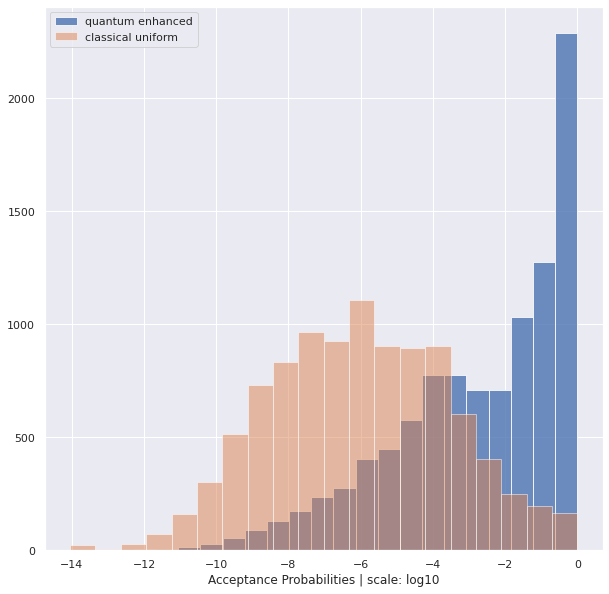

In [15]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qumcm_statistic['acceptance']),label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(np.log10(cl_statistic['acceptance']),label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

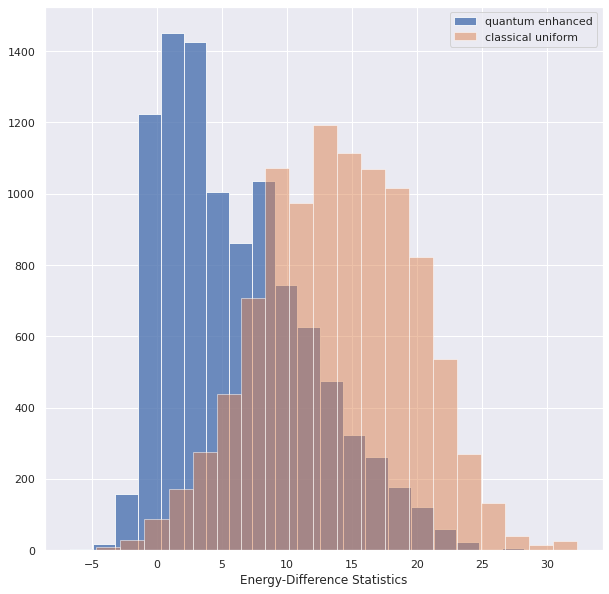

In [16]:
plt.figure(figsize=(10,10))

plt.hist(qumcm_statistic['energy'],label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(cl_statistic['energy'],label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Energy-Difference Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

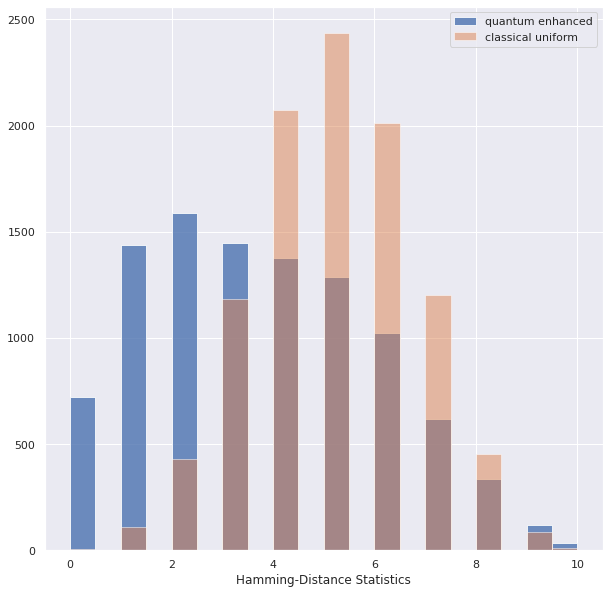

In [17]:
plt.figure(figsize=(10,10))

plt.hist(qumcm_statistic['hamming'],label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(cl_statistic['hamming'],label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

#### **Convergence Analysis**

##### Magnetisation

In [18]:
magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cl_chain)
magnetization_q = calculate_runnning_magnetisation(qamcmc_chain)

100%|██████████| 10000/10000 [00:16<00:00, 623.23it/s]


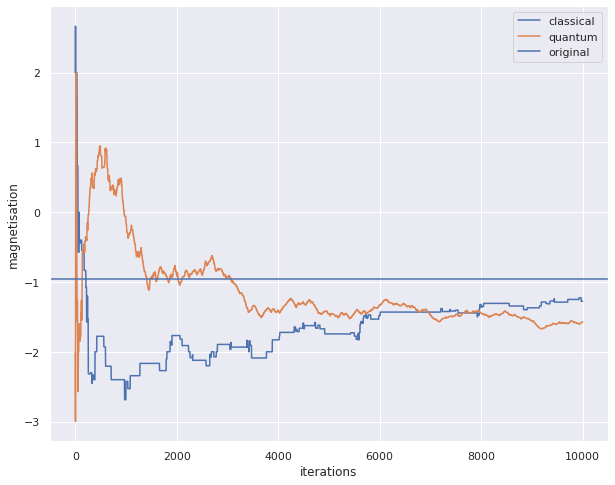

In [19]:
plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical')
plt.plot(magnetization_q, label= 'quantum')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

##### KL Divergence

In [21]:
jsdiv_c = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, cl_chain)
jsdiv_q = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain)

 64%|██████▍   | 6441/10000 [01:10<00:39, 90.45it/s] 

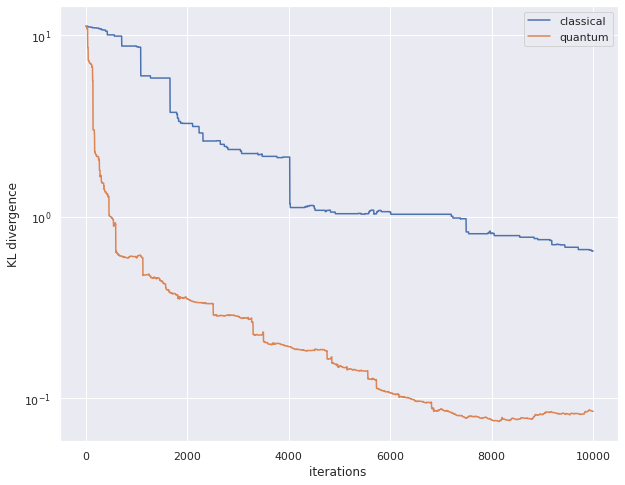

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(jsdiv_c, label= 'classical')
plt.plot(jsdiv_q, label= 'quantum')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()
